In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import math
import torch.nn.functional as F


from models import Encoder, Decoder
from flows import MAF


In [1]:
import torch

In [2]:
from models import Encoder, Decoder
from flows import MAF

In [21]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
bkg_data = torch.load("/eos/user/m/maglowac/Phase2_AD/data_utils/MinBias_with_ID_small.pt").float()[:150_000, 0:100, :]
sig_data = torch.load("/eos/user/m/maglowac/Phase2_AD/data_utils/HH4B_with_ID_small.pt").float()[:, 0:100, :]

In [24]:
def log_data(data):

    logged_data = data.clone()  # Create a clone to keep the original data unchanged
    first_column = logged_data[:, :, 0]  # Extract the first column

    # Apply np.log where the values are non-zero
    mask = first_column != 0  # Mask for non-zero values
    first_column[mask] = torch.log(first_column[mask])  # Apply log only to non-zero entries

    # Save the modified first column back
    data[:, :, 0] = first_column

    return data

In [25]:
unique_values, indices = torch.unique(bkg_data[:, :, 3], sorted=True, return_inverse=True)
bkg_data[:, :, 3] = indices.float()

In [26]:
unique_values, indices = torch.unique(sig_data[:, :, 3], sorted=True, return_inverse=True)
sig_data[:, :, 3] = indices.float()

In [27]:
bkg_data = log_data(bkg_data)
sig_data = log_data(sig_data)

In [28]:
class Dataset(Dataset):
    def __init__(self, data, num_pid_classes):
        self.data = data[:, :, 0:3]
        self.pid = data[:, :, 3].long()  # Ensure PID is integer
        self.num_pid_classes = num_pid_classes
        # Create the mask where the first column is non-zero
        self.mask = (data[:, :, 0] != 0).float()  # Shape: [samples, seq_length]

    def __len__(self):
        return self.data.size(0)  # Number of samples

    def __getitem__(self, idx):
        # One-hot encode the PID
        one_hot_pid = F.one_hot(abs(self.pid[idx]), num_classes=self.num_pid_classes).float()
        return {
            "kin": self.data[idx],       # Kinematic features
            "pid": one_hot_pid,          # One-hot encoded PID
            "mask": self.mask[idx]       # Mask for valid entries
        }

# Create the dataset
dataset_bkg = Dataset(bkg_data, 9)
dataset_sig = Dataset(sig_data, 9)

# Create the Data

batch_size = 1024 # Define batch size
bkg_loader = DataLoader(dataset_bkg, batch_size=batch_size, shuffle=False)
sig_loader = DataLoader(dataset_sig, batch_size=batch_size, shuffle=False)

In [29]:
class DeepsetSetVAE(nn.Module):
    def __init__(self, hparams):
        super(DeepsetSetVAE, self).__init__()
        self.hparams = hparams
        self.encoder = Encoder(d_kin=hparams['d_kin'], d_pid=hparams['d_pid'], use_pid=hparams['use_pid'], d_latent=hparams['d_latent']) 
        self.decoder = Decoder(d_pid=hparams['d_pid'], use_pid=hparams['use_pid'], d_latent=hparams['d_latent'])  
        self.angular_scale = hparams['angular_scale']


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z0 = mu + eps * std
        return z0
    
    def forward(self, x, pid, mask):
        # Run Encoder and get NF params
        mu, log_var = self.encoder(x, pid, mask)
    
        z = self.reparameterize(mu, log_var)

        #z_k, _, sum_ladj = self.flows(z)
 
        x_prime = self.decoder(z, pid, mask)
        return x_prime, mu, log_var
    


In [30]:
def l2_loss(x, y, angular_scale):
    """
    Compute L2 loss in spherical coordinates, which is defined as 
    |pT' - pT|^2 - pT^2 * [(eta - eta')^2 + (phi - phi')^2] / R_0^2
    """
    return (
        (x[..., 0] - y[..., 0]).square() +
        x[..., 0].square() * ((x[..., 1:3] - y[..., 1:3]) / angular_scale).square().sum(-1)
    )

def reco_loss(x_recon, x_input, pid, mask, angular_scale):
    """
    Compute reconstruction loss between `x_recon` and `x_input` based on the L2 distance in spherical coordinates.
    """
    # Ensure mask is a Boolean tensor
    mask = mask.bool()  # Converts mask to Boolean type if not already

    # Process mask and weights
    weights = mask.float() / mask.float().sum(1, keepdim=True)  # Normalized weights

    # Apply mask to `x_recon` and `x_input`
    x_recon = x_recon.clone()
    x_input = x_input[:, :x_recon.shape[1]]  # Adjust `x_input` to match `x_recon` shape
    x_recon.masked_fill_(~mask[:, :, None], 0)
    x_input.masked_fill_(~mask[:, :, None], 0)

    

    # Compute pairwise distance matrix
    dist_mat = l2_loss(
        x_recon[:, :, None],  # (batch_size, seq_len, 1, d_output)
        x_input[:, None, :],  # (batch_size, 1, seq_len, d_output)
        angular_scale
    )



    # Mask invalid distances (non-matching particles or invalid indices)
    pid = pid.argmax(-1)  # Get the most likely PID
    dist_mat.masked_fill_(
        ~(mask[:, :, None] & mask[:, None, :]) | (pid[:, :, None] != pid[:, None, :]),
        dist_mat.max().item() + 1  # Large value to exclude invalid distances
    )

    # Compute forward and backward Chamfer distances
    forward_dist = torch.amin(dist_mat, dim=2)  # Minimum distance for each reconstructed particle
    backward_dist = torch.amin(dist_mat, dim=1)  # Minimum distance for each original particle

    # Weighted sum of distances
    loss = 0.5 * weights * (forward_dist + backward_dist)


    # Aggregate losses per sample
    return loss.sum(dim=1)  # Shape: (batch_size,)



In [31]:
def kl_div_loss(mu, log_var):
    """
    mu: [N, C]
    log_var: [N, C]
    """        
    loss = -0.5 * torch.mean(
        1 + log_var - mu ** 2 - torch.exp(log_var),
        dim = -1
    )
    return loss


In [32]:
def vae_loss(x_recon, x_input, pid, mu,log_var, mask, angular_scale, beta):

    reconstruction_loss = reco_loss(x_recon, x_input, pid, mask, angular_scale)  
    kl_loss = kl_div_loss(mu, log_var)  
    idxs =torch.argsort(reconstruction_loss, dim=0)
    idxs = idxs[:int(len(idxs) * 0.75)] 
    loss = (reconstruction_loss.mean()) +  beta *kl_loss[idxs].mean()
    
    return loss, reconstruction_loss, kl_loss


In [35]:
hparams = {
    "model": DeepsetSetVAE,
    "d_kin": 3,
    "d_pid": 9,
    "use_pid": True,
    "d_model": 64,
    "d_latent": 16,  # Increased latent dimensionality
    "d_ff": 128,
    "d_output": 3,
    "n_encoder_layers": 4,
    "n_decoder_layers": 4,
    "maf_hidden_size": 8,
    "num_maf_layers": 5,
    "dropout": 0.,
    "beta": 0.08,  # Start with a small nonzero beta
    "angular_scale": 0.1,
    "lr": 0.0005,  # Reduced learning rate
    "batch_size": 1024,
    "warmup": 100,
    "patience": 10,
    "factor": 1.0,
    "soft_kl_steps": 10000,  # Faster KL annealing
    "latent_reg_weight": 0.1
}


In [36]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import roc_curve, auc

import torch.optim as optim

# Instantiate the model
model = DeepsetSetVAE(hparams)
model.train()

# Move model to device (CPU or GPU)
device = torch.device('cuda')
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])

# Scheduler (if needed)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=hparams['patience'], gamma=hparams['factor'])

# Training parameters
num_epochs = 100  # Adjust as needed
global_step = 0


# Early stopping parameters
patience = 5           # Number of epochs to wait for improvement
best_efficiency = 0.0  # Track the best 10 kHz efficiency
wait = 0               # How many epochs since last improvement

for epoch in range(num_epochs):
    model.train()
    for batch in bkg_loader:
        global_step += 1
        
        kin = batch['kin'].to(device)    # (batch_size, seq_len, d_kin)
        mask = batch['mask'].to(device)  # (batch_size, seq_len)
        pid = batch['pid'].to(device)

        # KL annealing
        beta = hparams['beta']
        if hparams['soft_kl_steps'] > 0:
            kl_weight = min(1.0, global_step / hparams['soft_kl_steps'])
            beta = hparams['beta'] * kl_weight

        # Forward pass
        x_prime, mu, log_var = model(kin, pid, mask)
        loss, reconstruction_loss, kl_divergence = vae_loss(
            x_prime, kin, pid, mu, log_var, mask, hparams['angular_scale'], beta
        )

        # Optional latent regularization
        # latent_regularization_loss = covariance_regularization(mu)
        # loss += hparams['latent_reg_weight'] * latent_regularization_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Learning rate warmup
        if global_step < hparams['warmup']:
            lr_scale = float(global_step) / float(max(1, hparams['warmup']))
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * hparams['lr']

    # Scheduler step
    if scheduler is not None:
        scheduler.step()

    # Evaluate on validation data
    model.eval()
    background_scores = []
    signal_scores = []

    with torch.no_grad():
        # Evaluate on background validation
        for batch in bkg_loader:
            kin = batch['kin'].to(device)
            mask = batch['mask'].to(device)
            pid = batch['pid'].to(device)

            x_prime, mu, log_var = model(kin, pid, mask)
            scores = torch.sum(mu ** 2, dim=1)
            background_scores.extend(scores.cpu().numpy())

        # Evaluate on signal validation
        for batch in sig_loader:
            kin = batch['kin'].to(device)
            mask = batch['mask'].to(device)
            pid = batch['pid'].to(device)

            x_prime, mu, log_var = model(kin, pid, mask)
            scores = torch.sum(mu ** 2, dim=1)
            signal_scores.extend(scores.cpu().numpy())

    background_scores = np.array(background_scores)
    signal_scores = np.array(signal_scores)

    # Compute ROC & AUC
    all_scores = np.concatenate([background_scores, signal_scores])
    all_labels = np.concatenate([
        np.zeros_like(background_scores),
        np.ones_like(signal_scores)
    ])

    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)

    # Convert FPR to kHz (adjust scaling as necessary)
    fpr_kHz = fpr * (40e3) * (2760 / 3564)

    # Find TPR at ~10 kHz FPR
    target_fpr_kHz = 10.0
    idx = np.argmin(np.abs(fpr_kHz - target_fpr_kHz))
    signal_eff_at_10kHz = tpr[idx]

    # Logging
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {loss.item():.4f}, "
          f"Recon: {reconstruction_loss.mean().item():.4f}, "
          f"KL: {kl_divergence.mean().item():.4f}, "
          f"Beta: {beta:.6f}, "
          f"Signal Eff @10kHz FPR: {signal_eff_at_10kHz:.4f}, "
          f"AUC: {roc_auc:.4f}")

    # Check for improvement in signal efficiency at 10 kHz FPR
    if signal_eff_at_10kHz > best_efficiency:
        best_efficiency = signal_eff_at_10kHz
        wait = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model_flows.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in signal efficiency.")
            break

# Optionally load the best model if needed:
# model.load_state_dict(torch.load('best_model.pth'))


Epoch [1/100] Loss: 0.1527, Recon: 0.1527, KL: 0.0129, Beta: 0.001176, Signal Eff @10kHz FPR: 0.0017, AUC: 0.7522
Epoch [2/100] Loss: 0.1031, Recon: 0.1030, KL: 0.0120, Beta: 0.002352, Signal Eff @10kHz FPR: 0.0017, AUC: 0.6913
Epoch [3/100] Loss: 0.0904, Recon: 0.0904, KL: 0.0146, Beta: 0.003528, Signal Eff @10kHz FPR: 0.0015, AUC: 0.7340
Epoch [4/100] Loss: 0.0835, Recon: 0.0834, KL: 0.0183, Beta: 0.004704, Signal Eff @10kHz FPR: 0.0017, AUC: 0.7368
Epoch [5/100] Loss: 0.0802, Recon: 0.0801, KL: 0.0216, Beta: 0.005880, Signal Eff @10kHz FPR: 0.0020, AUC: 0.7547
Epoch [6/100] Loss: 0.0783, Recon: 0.0782, KL: 0.0239, Beta: 0.007056, Signal Eff @10kHz FPR: 0.0026, AUC: 0.7779
Epoch [7/100] Loss: 0.0773, Recon: 0.0772, KL: 0.0233, Beta: 0.008232, Signal Eff @10kHz FPR: 0.0025, AUC: 0.8198
Epoch [8/100] Loss: 0.0766, Recon: 0.0765, KL: 0.0203, Beta: 0.009408, Signal Eff @10kHz FPR: 0.0027, AUC: 0.8349
Epoch [9/100] Loss: 0.0762, Recon: 0.0761, KL: 0.0168, Beta: 0.010584, Signal Eff @10kHz

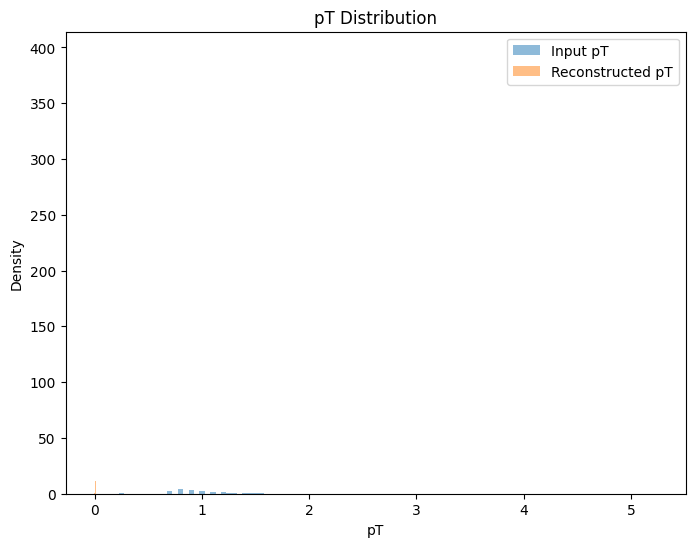

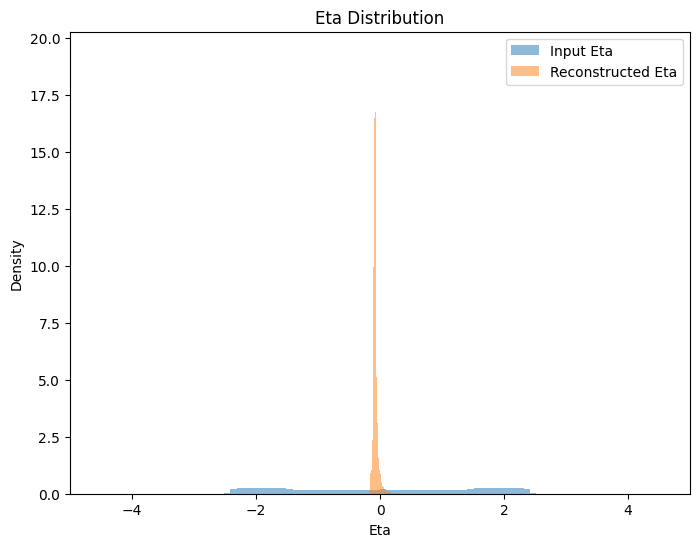

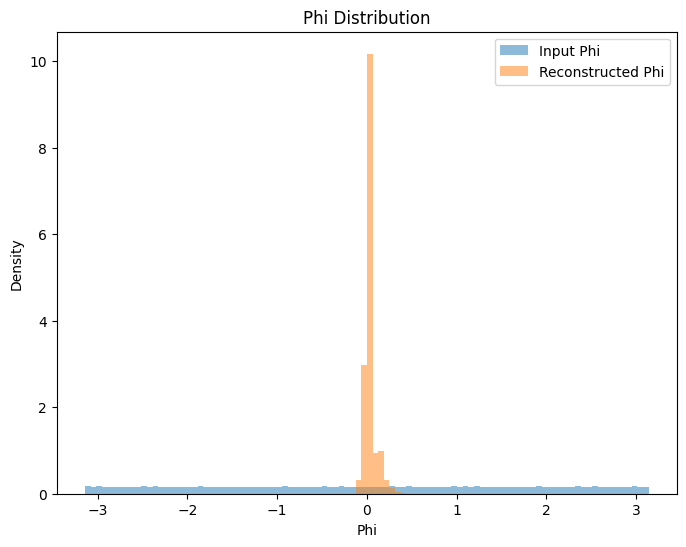

In [23]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import mean_absolute_error

# Set the model to evaluation mode
model.eval()

# Initialize lists to collect kinematic features
pt_input_list = []
eta_input_list = []
phi_input_list = []

pt_recon_list = []
eta_recon_list = []
phi_recon_list = []

device = torch.device('cuda')

with torch.no_grad():
    for batch in bkg_loader:  # Assume train_loader provides batches of data

        # Extract data from batch and move to device
        kin = batch['kin'].to(device)    # Shape: (batch_size, seq_len, d_kin)
        mask = batch['mask'].to(device)  # Shape: (batch_size, seq_len)
        pid = batch['pid'].to(device)

        # Forward pass
        x_recon, mu, log_var = model(kin, pid, mask)

        # Move tensors to CPU and convert to numpy arrays
        x_input_np = kin.cpu().numpy()
        x_recon_np = x_recon.cpu().numpy()
        mask_np = mask.cpu().numpy()

        # Flatten the arrays
        x_input_flat = x_input_np.reshape(-1, 3)
        x_recon_flat = x_recon_np.reshape(-1, 3)
        mask_flat = mask_np.flatten()

        # Select valid (non-masked) particles
        valid_indices = mask_flat == 1

        x_input_valid = x_input_flat[valid_indices]
        x_recon_valid = x_recon_flat[valid_indices]

        # Extract kinematic features
        pt_input_list.append(x_input_valid[:, 0])
        eta_input_list.append(x_input_valid[:, 1])
        phi_input_list.append(x_input_valid[:, 2])

        pt_recon_list.append(x_recon_valid[:, 0])
        eta_recon_list.append(x_recon_valid[:, 1])
        phi_recon_list.append(x_recon_valid[:, 2])

# Concatenate lists to get arrays
pt_input_all = np.concatenate(pt_input_list)
eta_input_all = np.concatenate(eta_input_list)
phi_input_all = np.concatenate(phi_input_list)

pt_recon_all = np.concatenate(pt_recon_list)
eta_recon_all = np.concatenate(eta_recon_list)
phi_recon_all = np.concatenate(phi_recon_list)


# Handle phi wrapping
phi_input_all = (phi_input_all + np.pi) % (2 * np.pi) - np.pi
phi_recon_all = (phi_recon_all + np.pi) % (2 * np.pi) - np.pi

# Plotting function
def plot_histogram(input_data, recon_data, feature_name, bins=100, log_scale=False, range=None, xlim=False):
    plt.figure(figsize=(8, 6))
    plt.hist(input_data, bins=bins, alpha=0.5, label=f'Input {feature_name}', density=True, range=range)
    plt.hist(recon_data, bins=100, alpha=0.5, label=f'Reconstructed {feature_name}', density=True, range=range)
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.legend()
    plt.title(f'{feature_name} Distribution')
    if log_scale:
        plt.yscale('log')
    if xlim:
        plt.xlim(-5,5)
    plt.show()

# Plot pT
plot_histogram(pt_input_all, pt_recon_all, 'pT', bins=100, log_scale=False, xlim=False)

# Plot eta
plot_histogram(eta_input_all, eta_recon_all, 'Eta', bins=100, xlim=True)

# Plot phi
plot_histogram(phi_input_all, phi_recon_all, 'Phi', bins=100, range=(-np.pi, np.pi))

# Compute and print MAE
#mae_pt = mean_absolute_error(pt_input_all, pt_recon_all)
#mae_eta = mean_absolute_error(eta_input_all, eta_recon_all)
#phi_diff = np.angle(np.exp(1j * (phi_input_all - phi_recon_all)))
#mae_phi = np.mean(np.abs(phi_diff))

#print(f'Mean Absolute Error for pT: {mae_pt:.4f}')
#print(f'Mean Absolute Error for eta: {mae_eta:.4f}')
#print(f'Mean Absolute Error for phi: {mae_phi:.4f}')


In [ ]:
def plot_histogram(input_data, recon_data, feature_name, bins=100, log_scale=False, range=None, xlim=False):
    plt.figure(figsize=(8, 6))
    plt.hist(input_data, bins=bins, alpha=0.5, label=f'Input {feature_name}', density=True, range=range)
    plt.hist(recon_data, bins=100, alpha=0.5, label=f'Reconstructed {feature_name}', density=True, range=range)
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.legend()
    plt.title(f'{feature_name} Distribution')
    if log_scale:
        plt.yscale('log')
    plt.ylim(0,1)
    plt.show()

# Plot pT
plot_histogram(pt_input_all, pt_recon_all, 'pT', bins=100, log_scale=False, xlim=False)